# 記述子とフィンガーブリントの作成

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Draw

from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

In [21]:
# train_dataの読み込み
train_df = pd.read_csv(r"C:\data\kaggle_Open_Polymer_2025\dataset_dawnload_from_kaggle\train.csv")
print(train_df.shape)
train_df.head()

(7973, 7)


,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


In [22]:
# SMILES列の抽出
train_smiles = train_df.iloc[:, 1]

In [23]:
# SMILESから分子オブジェクトへの変換
train_mols = [Chem.MolFromSmiles(smiles) for smiles in train_smiles]

# 記述子の計算

In [24]:
descriptor_names = []
for descriptor_information in Descriptors.descList:
    descriptor_names.append(descriptor_information[0])

print('計算する記述子の数 :', len(descriptor_names))

計算する記述子の数 : 217


In [25]:
descriptor_calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

descriptors_train = []  # ここに計算された記述子の値を追加

for index, smiles_i in enumerate(train_smiles):
    # print(index + 1, '/', len(train_smiles))
    molecule = Chem.MolFromSmiles(smiles_i)
    descriptors_train.append(descriptor_calculator.CalcDescriptors(molecule))
descriptors_train = pd.DataFrame(descriptors_train, index=train_df.index, columns=descriptor_names)

In [30]:
descriptors_train.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.144536,12.144536,0.105927,-0.105927,0.500278,13.705882,232.323,212.163,232.146330,92,...,0,0,0,0,0,0,0,0,3,0
1,3.523412,3.523412,0.098918,0.098918,0.125364,16.777778,598.919,544.487,598.428700,236,...,0,0,0,0,0,0,0,0,2,0
2,13.714745,13.714745,0.107441,-3.829434,0.092387,16.301370,1003.207,952.807,1002.289625,364,...,0,0,2,0,0,0,0,0,0,0
3,3.978671,3.978671,0.054569,-0.202102,0.209590,11.523810,542.726,508.454,542.272199,204,...,0,0,0,0,0,0,0,0,0,0
4,13.703218,13.703218,0.068062,-0.686332,0.014164,15.885714,965.154,896.610,964.483374,376,...,0,0,0,0,0,0,0,0,12,0


記述子計算後の後処理

In [43]:
def select_col(df):
    # 0. 初期のカラム数を表示
    print(f"Initial number of columns: {len(df.columns)}")
    
    # 1. 無限大な値をNaNに置換
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # 2. 明らかに大きすぎる値（float32オーバーフロー）をNaNにする
    max_float32 = np.finfo(np.float32).max
    df = df.where(df.abs() <= max_float32, np.nan)

    # 3. 欠損値のあるカラムを削除
    df = df.dropna(axis=1)
    print(f"After dropping columns with missing values: {len(df.columns)}")

    # 4. 標準偏差が0（すべての値が同じ）のカラムを削除
    df = df.loc[:, df.std(numeric_only=True) != 0]
    print(f"After dropping columns with zero standard deviation: {len(df.columns)}")

    return df

descriptors_train_selected = select_col(descriptors_train)

Initial number of columns: 217
After dropping columns with missing values: 204
After dropping columns with zero standard deviation: 192


PCAで記述子の次元削減

In [44]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [45]:
# 正規化
sc = StandardScaler().fit(descriptors_train_selected)
descriptors_train_scaled = sc.transform(descriptors_train_selected)

descriptors_train_scaled = pd.DataFrame(descriptors_train_scaled, columns=descriptors_train_selected.columns)

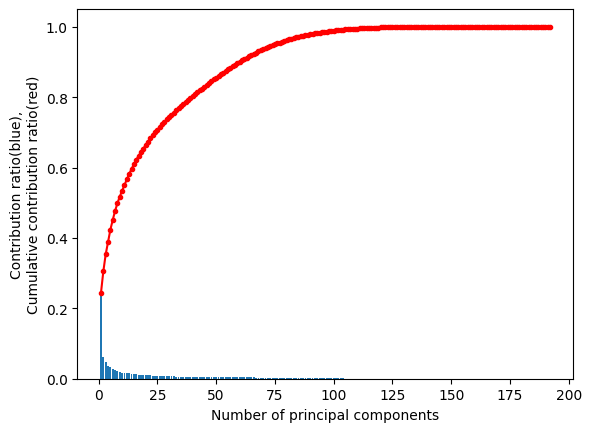

In [ ]:
# PCA
pca = PCA() # n_components=0.95等を代入
pca.fit(descriptors_train_scaled)  # PCA を実行
# ローディング
loadings = pd.DataFrame(pca.components_.T, index=descriptors_train_scaled.columns)
# loadings.to_csv('pca_loadings.csv')
# スコア
score = pd.DataFrame(pca.transform(descriptors_train_scaled), index=descriptors_train_scaled.index)
#score.to_csv('pca_score.csv')
# 寄与率、累積寄与率
contribution_ratios = pd.DataFrame(pca.explained_variance_ratio_)  # 寄与率を DataFrame 型に変換
cumulative_contribution_ratios = contribution_ratios.cumsum()  # cumsum() で寄与率の累積和を計算
cont_cumcont_ratios = pd.concat(
    [contribution_ratios, cumulative_contribution_ratios],
    axis=1).T
cont_cumcont_ratios.index = ['contribution_ratio', 'cumulative_contribution_ratio']  # 行の名前を変更
# cont_cumcont_ratios.to_csv('pca_cont_cumcont_ratios.csv')

# 寄与率を棒グラフで、累積寄与率を線で入れたプロット図を重ねて描画
x_axis = range(1, contribution_ratios.shape[0] + 1)  # 1 から成分数までの整数が x 軸の値
plt.bar(x_axis, contribution_ratios.iloc[:, 0], align='center')  # 寄与率の棒グラフ
plt.plot(x_axis, cumulative_contribution_ratios.iloc[:, 0], 'r.-')  # 累積寄与率の線を入れたプロット図
plt.xlabel('Number of principal components')  # 横軸の名前
plt.ylabel('Contribution ratio(blue),\nCumulative contribution ratio(red)')  # 縦軸の名前。\n で改行しています
plt.show()

In [63]:
# ここまでを出力
descriptors_train_scaled.to_csv('mordred_train_scaled.csv', index=False)
score.to_csv('train_pca.csv', index=False)


# 記述子（Mordred Ver.）

In [47]:
from mordred import Calculator, descriptors

In [48]:
# Mordred記述子の準備（すべての記述子、3D記述子は除外）
calc = Calculator(descriptors, ignore_3D=True)

# 分子の数
print('分子の数 :', len(train_smiles))

分子の数 : 7973


In [49]:
# 記述子の計算(時間がかかるので注意)
mols = [Chem.MolFromSmiles(smi) for smi in train_smiles]
mordred_train = calc.pandas(mols)  # DataFrame形式で取得

  0%|          | 25/7973 [00:05<14:52,  8.90it/s]  

c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in redu

  0%|          | 34/7973 [00:06<16:06,  8.22it/s]

c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  1%|          | 71/7973 [00:07<05:23, 24.40it/s]

c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  1%|          | 92/7973 [00:09<08:34, 15.33it/s]

c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  3%|▎         | 214/7973 [00:13<10:45, 12.03it/s]

c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  4%|▍         | 335/7973 [00:18<05:27, 23.35it/s]

c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 7973/7973 [06:04<00:00, 21.90it/s]


後処理

In [52]:
print(mordred_train.shape)

# 欠損値を含む記述子（カラム）を削除
mordred_train = mordred_train.dropna(axis=1)
print(mordred_train.shape)

# 数値型の列だけを残す（float, intなど）
descriptors_numeric = mordred_train.select_dtypes(include=['number'])
print(descriptors_numeric.shape)

# 標準偏差が0の列を削除
zero_std_columns = descriptors_numeric.std()[descriptors_numeric.std() == 0].index
mordred_train = descriptors_numeric.drop(columns=zero_std_columns)
print(mordred_train.shape)


(7973, 1613)
(7973, 1584)
(7973, 686)
(7973, 569)


In [53]:
mordred_train.to_csv('mordred_train.csv', index=False)

# FingerPrintの計算

In [54]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

In [ ]:
fp_type = 2  # 0: MACCS key, 1: RDKit, 2: Morgan, 3: Avalon
fp_train = []

for index, smiles_i in enumerate(train_smiles):
    #print(index + 1, '/', len(smiles))
    molecule = Chem.MolFromSmiles(smiles_i)
    if fp_type == 0:
        fp_train.append(AllChem.GetMACCSKeysfp(molecule))
    elif fp_type == 1:
        fp_train.append(Chem.RDKfp(molecule))
    elif fp_type == 2:
        morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)
        morgan_fps = morgan_gen.GetFingerprint(molecule)
        fp_train.append(morgan_fps)
    elif fp_type == 3:
        fp_train.append(GetAvalonFP(molecule))
        
fp_train = pd.DataFrame(np.array(fp_train, int), index=train_df.index)

In [ ]:
# カラム名を変更
fp_names = []
for i in range(2048):
    fp_names.append(f"FP_{i}")

fp_train.columns = fp_names
fp_train.head()

,FP_0,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,...,FP_2038,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# 標準偏差が０のカラムを削除
print(f"Initial number of columns: {len(fp_train.columns)}")
fp_train = fp_train.loc[:, fp_train.std(numeric_only=True) != 0]
print(f"After dropping columns with zero standard deviation: {len(fp_train.columns)}")

Initial number of columns: 2048
After dropping columns with zero standard deviation: 2047


In [62]:
!jupyter nbconvert --to html RDKIT_descriptors.ipynb

[NbConvertApp] Converting notebook RDKIT_descriptors.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 355561 bytes to RDKIT_descriptors.html
